In [455]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.metrics as metrics
import missingno as msno
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV

I will begin by importing the train and test data, adding a column that differentiates between both sets, concatenating the two data sets, cleaning the data, and adding transformations and dummy variables as needed.

I will then split the data into train and test before creating a model

# Data Import

In [456]:
# import train data
house_train = pd.read_csv('../datasets/train.csv')
house_train.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000


In [457]:
# import test data
house_test = pd.read_csv('../datasets/test.csv')
house_test.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD


In [458]:
# add column to differentiate between train (1) and test (0) data sets
house_train['data_type'] = 1
house_test['data_type'] = 0

In [459]:
# concatenate the data to clean/transform as needed
frames = [house_train, house_test]
df = pd.concat(frames)

In [460]:
# check that data was concatenated correctly
print(house_train.shape)
print(house_test.shape)
print(df.shape)
print(house_train.shape[0] + house_test.shape[0] == df.shape[0])

(2051, 82)
(878, 81)
(2929, 82)
True


In [461]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2929 entries, 0 to 877
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2929 non-null   int64  
 1   PID              2929 non-null   int64  
 2   MS SubClass      2929 non-null   int64  
 3   MS Zoning        2929 non-null   object 
 4   Lot Frontage     2439 non-null   float64
 5   Lot Area         2929 non-null   int64  
 6   Street           2929 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2929 non-null   object 
 9   Land Contour     2929 non-null   object 
 10  Utilities        2929 non-null   object 
 11  Lot Config       2929 non-null   object 
 12  Land Slope       2929 non-null   object 
 13  Neighborhood     2929 non-null   object 
 14  Condition 1      2929 non-null   object 
 15  Condition 2      2929 non-null   object 
 16  Bldg Type        2929 non-null   object 
 17  House Style    

In [462]:
# SalePrice shows as NaN for test data as expected
df.tail(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,data_type
876,1672,527425140,20,RL,60.0,9000,Pave,NaN,Reg,Lvl,...,0,NaN,GdWo,NaN,0,5,2007,WD,NaN,0
877,1939,535327160,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,...,0,NaN,GdWo,NaN,0,3,2007,WD,NaN,0


# Cleaning Data and EDA

In [463]:
df.isnull().sum()[df.isnull().sum()>0]

Lot Frontage       490
Alley             2731
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2916
Fence             2357
Misc Feature      2823
SalePrice          878
dtype: int64

In [464]:
# When I plot the missing values for the full data set, train, and test separately, the graphs appear pretty similar. 
# Those null values may need to be zero instead per the data dictionary

In [465]:
# check nulls
df[(df['Alley'].isnull()) & (df['data_type'] == 1)]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,data_type
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,130500.0,1
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,220000.0,1
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2010,WD,109000.0,1
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,174000.0,1
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,138500.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,20,RL,79.0,11449,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,1,2008,WD,298751.0,1
2047,785,905377130,30,RL,NaN,12342,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2009,WD,82500.0,1
2048,916,909253010,50,RL,57.0,7558,Pave,NaN,Reg,Bnk,...,0,NaN,NaN,NaN,0,3,2009,WD,177000.0,1
2049,639,535179160,20,RL,80.0,10400,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,11,2009,WD,144000.0,1


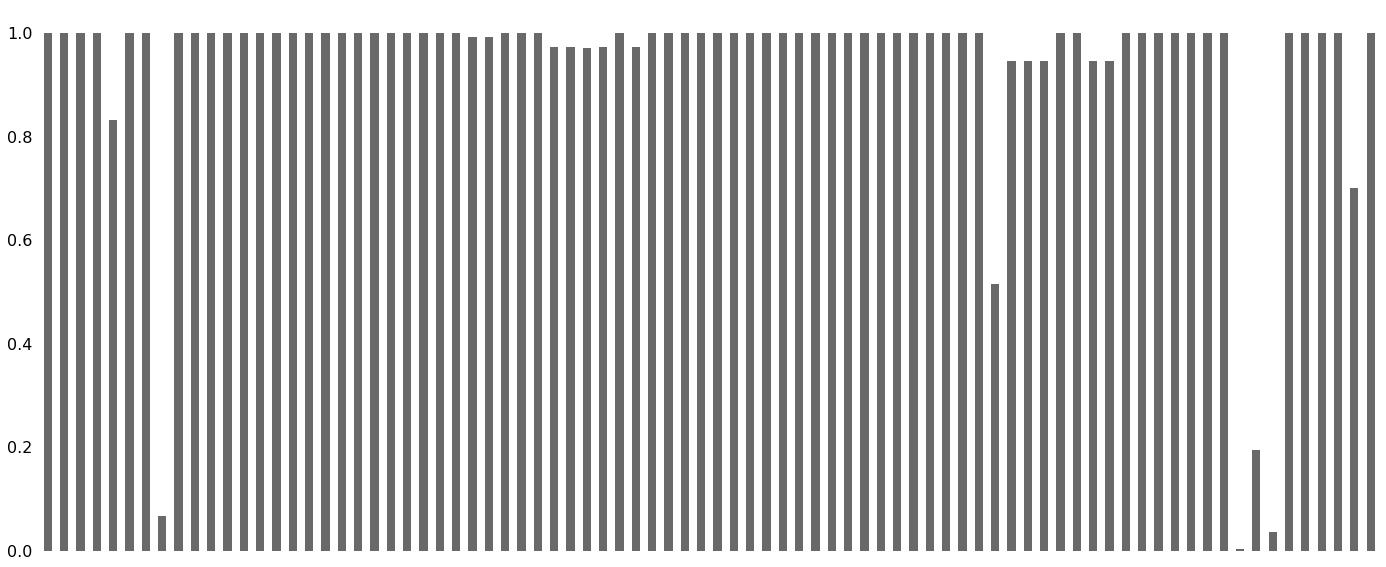

In [466]:
msno.bar(df)

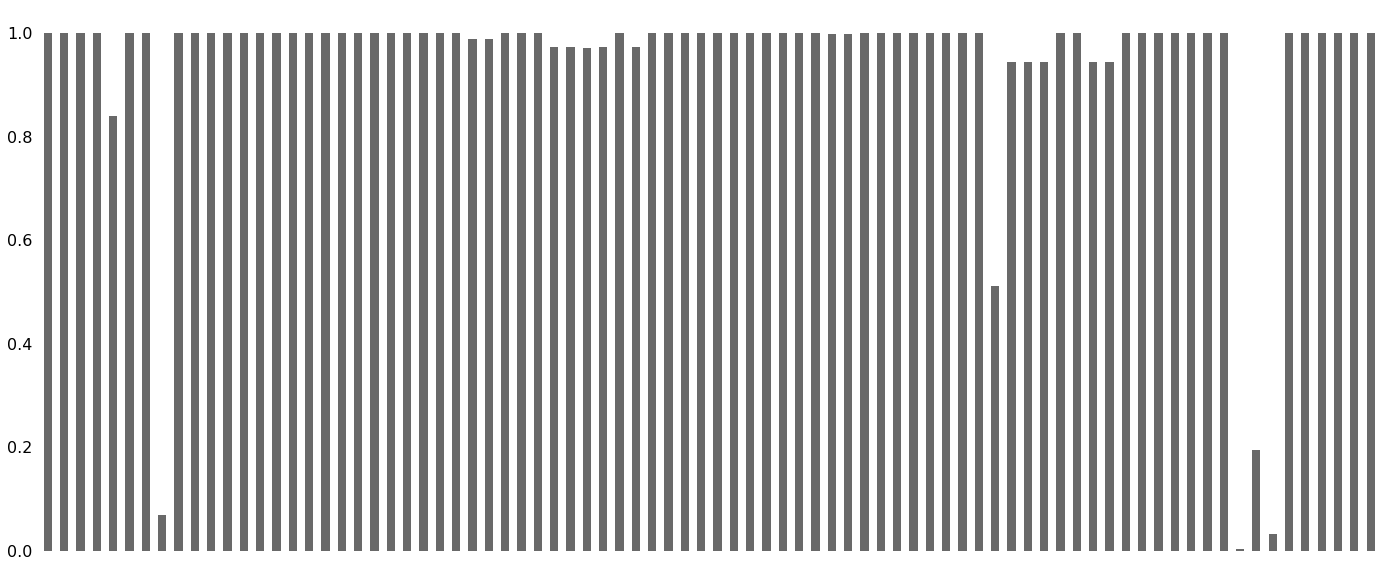

In [467]:
# bar plot of missing values for test data set
msno.bar(df[df['data_type'] == 1])

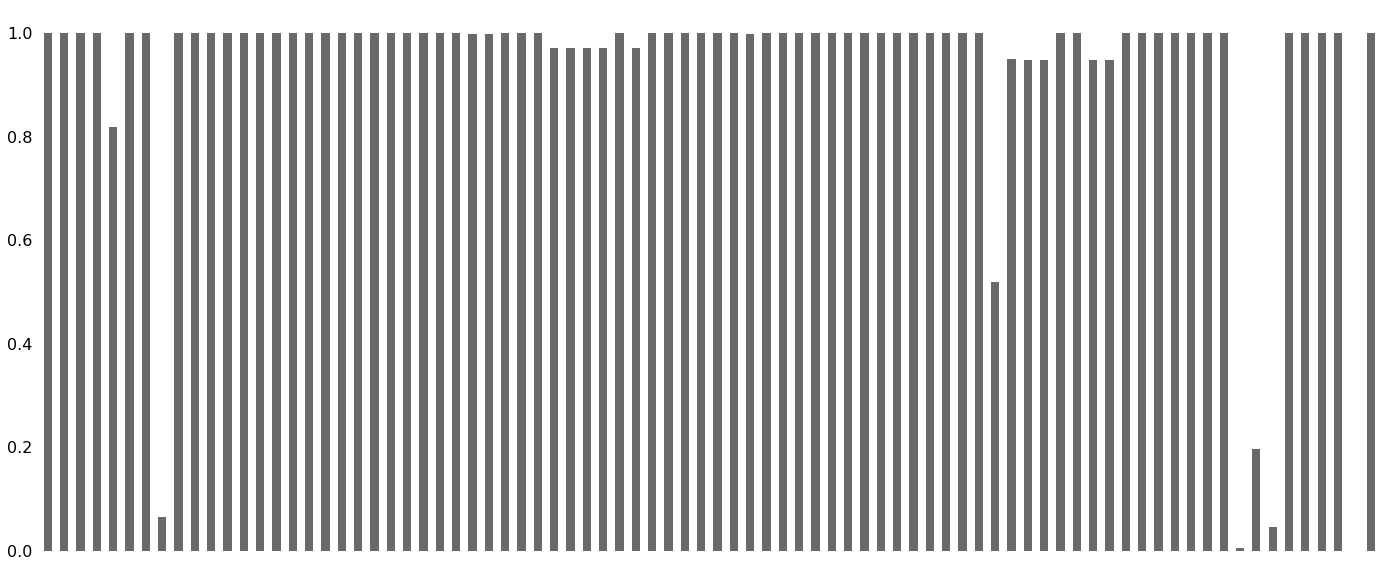

In [468]:
# bar plot of missing values for test data set
msno.bar(df[df['data_type'] == 0])

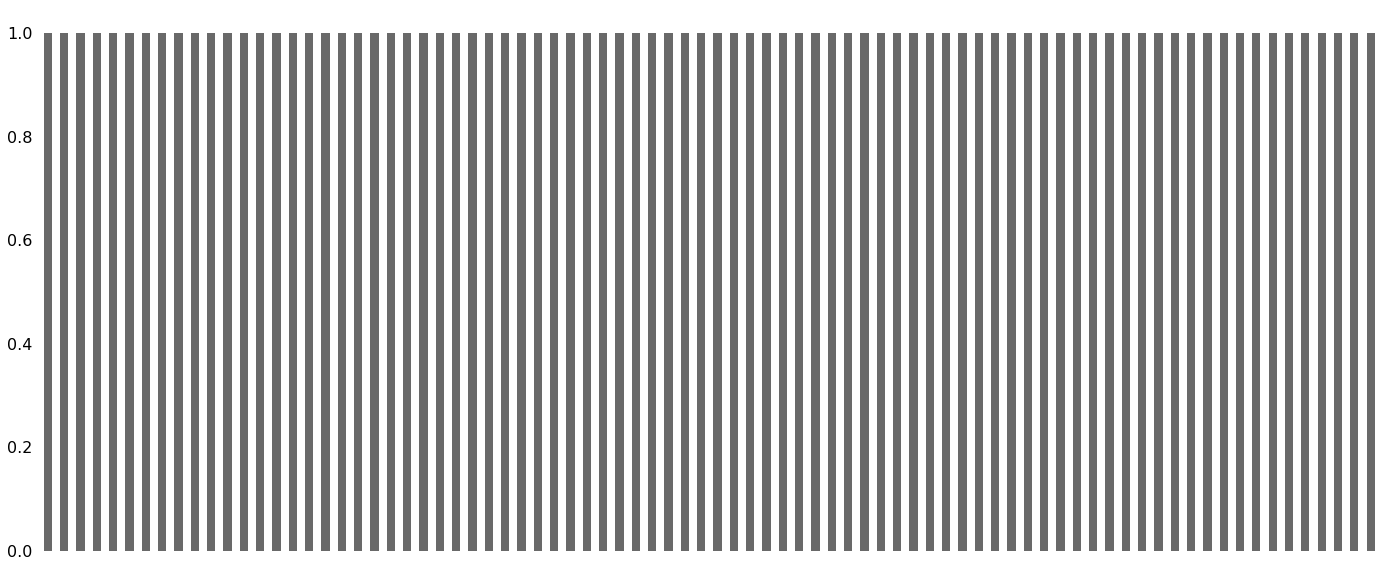

In [469]:
# I am going to fill the null values with zero since for the most case null values mean there is no sqft, garage, etc.
df.fillna(0, inplace = True)
msno.bar(df)

# Remove Outliers

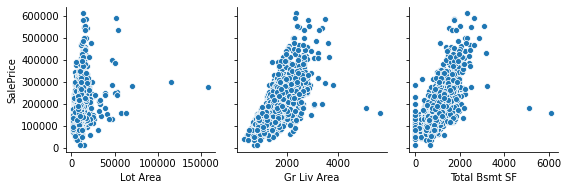

In [470]:
# There below graphs have what appear to be outliers
sns.pairplot(df[df['data_type'] == 1], x_vars = ['Lot Area', 'Gr Liv Area', 'Total Bsmt SF'], y_vars = ['SalePrice']);

In [471]:
# Lot Area
df[df['data_type'] == 1].sort_values('Lot Area').tail(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,data_type
694,2072,905301050,20,RL,0.0,115149,Pave,0,IR2,Low,...,0,0,0,0,0,6,2007,WD,302000.0,1
471,2116,906426060,50,RL,0.0,159000,Pave,0,IR2,Low,...,0,0,0,Shed,500,6,2007,WD,277000.0,1


In [472]:
# Gr Liv Area
df[df['data_type'] == 1].sort_values('Gr Liv Area').tail(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,data_type
1885,2181,908154195,20,RL,128.0,39290,Pave,0,IR1,Bnk,...,0,0,0,Elev,17000,10,2007,New,183850.0,1
960,1499,908154235,60,RL,313.0,63887,Pave,0,IR3,Bnk,...,480,Gd,0,0,0,1,2008,New,160000.0,1


In [473]:
# Total Bsmt SF
df[df['data_type'] == 1].sort_values('Total Bsmt SF').tail(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,data_type
1885,2181,908154195,20,RL,128.0,39290,Pave,0,IR1,Bnk,...,0,0,0,Elev,17000,10,2007,New,183850.0,1
960,1499,908154235,60,RL,313.0,63887,Pave,0,IR3,Bnk,...,480,Gd,0,0,0,1,2008,New,160000.0,1


In [474]:
#I am going to delete the four data points that appear to be outliers 
df = df.drop(index = [694, 471, 1885, 960])

# Creating New Features

In [475]:
# I am going to create one term to count total bathrooms
df['total_baths'] = df['Bsmt Full Bath'] + 0.5*df['Bsmt Half Bath'] + df['Full Bath'] + df['Half Bath']


# Visuals - Looking at correlations and other relationships

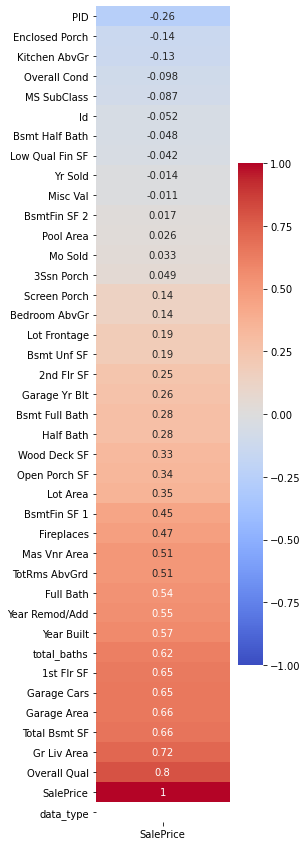

In [476]:
plt.figure(figsize = (3,15))
sns.heatmap(df[df['data_type'] == 1].corr()[['SalePrice']].sort_values('SalePrice'),
                       annot = True,
                       cmap = 'coolwarm',
                       vmin = -1,
                       vmax = 1);

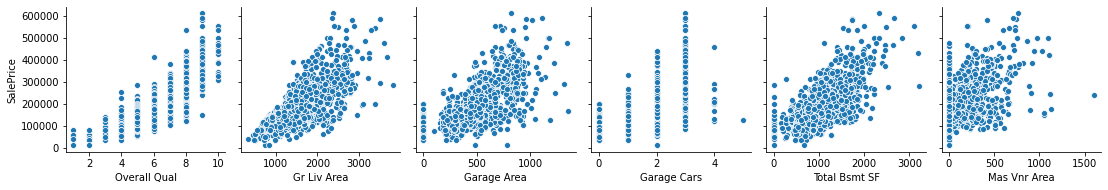

In [477]:
sns.pairplot(df[df['data_type'] == 1], x_vars = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars', 'Total Bsmt SF', 'Mas Vnr Area'], y_vars = ['SalePrice']);


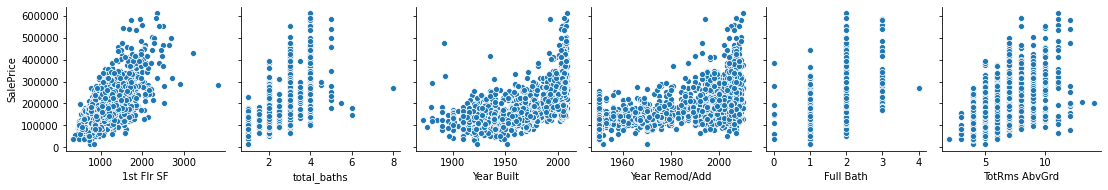

In [478]:
sns.pairplot(df[df['data_type'] == 1], x_vars = ['1st Flr SF', 'total_baths', 'Year Built', 'Year Remod/Add', 'Full Bath', 'TotRms AbvGrd'], y_vars = ['SalePrice']);

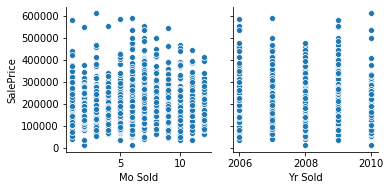

In [479]:
sns.pairplot(df[df['data_type'] == 1], x_vars = ['Mo Sold', 'Yr Sold'], y_vars = ['SalePrice']);


In [480]:
features = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars', 'Total Bsmt SF', 'Mas Vnr Area', '1st Flr SF', 'total_baths', 'Year Built', 'Year Remod/Add', 'Full Bath', 'TotRms AbvGrd', 'Mo Sold', 'Yr Sold', 'SalePrice', 'data_type']

In [481]:
new_df = df[features]

In [482]:
new_df = pd.get_dummies(new_df, columns = ['Mo Sold', 'Yr Sold'])

In [483]:
new_df_y_train = new_df[new_df['data_type'] == 1]['SalePrice']
new_df_y_test = new_df[new_df['data_type'] == 0]['SalePrice']
new_df_X_train = new_df[new_df['data_type'] == 1].drop(columns = ['data_type', 'SalePrice'])
new_df_X_test = new_df[new_df['data_type'] == 0].drop(columns = ['data_type', 'SalePrice'])

In [484]:
# # I am going to add interactions to my df using PolynomialFeatures
# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# df_overfit_train = poly.fit_transform(new_df_X_train)
# df_overfit_test = poly.fit_transform(new_df_X_test)

In [485]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(new_df_X_train, new_df_y_train, random_state = 42)

In [ ]:
y_rain

In [486]:
# Standard Scalar, though it's not recommended to do on encoded
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [487]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-3, 100, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas = l_alphas)

# Fit model using best ridge alpha!
lasso_cv.fit(Z_train, y_train)

/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=array([1.00000e-003, 1.09750e-002, ..., 9.11163e+098, 1.00000e+100]),
    copy_X=True, cv='warn', eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [488]:
print(lasso_cv.score(Z_train, y_train))
print(lasso_cv.score(Z_test, y_test))

0.8482334516533081
0.8324896889069404


In [489]:
y_pred_train = lasso_cv.predict(X_train)
y_pred_test = lasso_cv.predict(X_test)

In [490]:
y_pred_train

array([6.93370820e+07, 6.17252375e+07, 1.21281242e+08, ...,
       1.03579565e+08, 7.36801933e+07, 9.78379458e+07])

In [491]:
y_train

273     129000.0
1915     87000.0
250     290000.0
413     139500.0
1339    132000.0
          ...   
1133    196500.0
1297    127500.0
862     221300.0
1462    164000.0
1129    232600.0
Name: SalePrice, Length: 1535, dtype: float64

In [302]:
model = sm.OLS(df_y, df_X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                              2687.
Date:                Wed, 08 Apr 2020   Prob (F-statistic):                        0.00
Time:                        22:14:35   Log-Likelihood:                         -24200.
No. Observations:                2049   AIC:                                  4.845e+04
Df Residuals:                    2022   BIC:                                  4.861e+04
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
MS SubClass     -137.6248     20.939     -6.573      0.000    -178.689     -96.561
Lot Frontage      44.9629     23.577      1.907      0.057      -1.275      91.201
Lot Area           0.5747      0.168      3.420      0.001       0.245       0.904
Overall Qual    2.055e+04    863.617     23.797      0.000    1.89e+04    2.22e+04
Overall Cond    3520.3844    810.138      4.345      0.000    1931.591    5109.177
Year Built       130.3069     41.318      3.154      0.002      49.278     211.336
Year Remod/Add  -157.2776     41.673     -3.774      0.000    -239.005     -75.550
Mas Vnr Area      31.0620      4.980      6.237      0.000      21.296      40.828
BsmtFin SF 1      11.8183      2.447      4.830      0.000       7.019      16.617
Total Bsmt SF      8.8848      3.145      2.825      0.005       2.717      15.053
1st Flr SF        44.8907     15.155      2.962      0.003      15.169      74.612
2nd Flr SF        37.2913     14.855      2.510      0.012       8.158      66.425
Gr Liv Area       -0.9110     14.844     -0.061      0.951     -30.022      28.200
Bsmt Full Bath  9638.8009   1879.549      5.128      0.000    5952.747    1.33e+04
Full Bath        1.12e+04   1996.830      5.611      0.000    7287.274    1.51e+04
Half Bath       4870.9888   2052.897      2.373      0.018     844.975    8897.003
Bedroom AbvGr  -8817.0051   1300.039     -6.782      0.000   -1.14e+04   -6267.449
Kitchen AbvGr  -2.324e+04   4286.819     -5.421      0.000   -3.16e+04   -1.48e+04
TotRms AbvGrd   4222.4633    982.544      4.297      0.000    2295.560    6149.367
Fireplaces      2499.2662   1413.235      1.768      0.077    -272.283    5270.815
Garage Yr Blt    -14.8090      2.150     -6.887      0.000     -19.026     -10.592
Garage Cars     1.188e+04   2403.995      4.942      0.000    7167.172    1.66e+04
Garage Area       22.8727      8.178      2.797      0.005       6.834      38.911
Wood Deck SF      27.5130      6.196      4.440      0.000      15.361      39.665
Screen Porch      70.9448     13.044      5.439      0.000      45.364      96.526
Pool Area       -101.2204     19.827     -5.105      0.000    -140.104     -62.337
Misc Val         -12.2330      1.313     -9.316      0.000     -14.808      -9.658
==============================================================================
Omnibus:                      798.448   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72683.189
Skew:                          -0.889   Prob(JB):                         0.00
Kurtosis:                      32.124   Cond. No.                     7.10e+04
==============================================================================

Warnings:
[1] Stand

In [310]:
mse_train = metrics.mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
rmse_train

84263583.67113435

In [311]:
mse_test = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
rmse_test

82745093.50018339

In [312]:
Neighborhood_Landmrk, Neighborhood_IDOTRR, Neighborhood_GrnHill, Neighborhood_Greens, Neighborhood_Crawfor, Neighborhood_BrDale, Neighborhood_Blueste, Neighborhood_Blmngtn, MS Zoning_RL, MS Zoning_RH, MS Zoning_FV, Yr Sold_2006, Misc Val, 3Ssn Porch, Id, PID, MS SubClass, Lot Frontage, Bsmt Unf SF, Low Qual Fin SF, Bsmt Full Bath, Bsmt Half Bath, Half Bath, Garage Yr Blt, Open Porch SF, Enclosed Porch

SyntaxError: invalid syntax (<ipython-input-312-89d724862734>, line 1)

In [ ]:
model = sm.OLS(df_y, df_X).fit()
model.summary()

In [ ]:
features_house = ['Garage Area', 'MS Zoning', 'Lot Area', 'Neighborhood', 'Mo Sold', 'Yr Sold', 'Overall Qual', 
            'Year Remod/Add', 'SalePrice', 'data_type']

In [ ]:
df = df[features_house]

In [ ]:
df = pd.get_dummies(df, columns = ['MS Zoning', 'Neighborhood', 'Mo Sold', 'Yr Sold', 'Year Remod/Add'])

In [ ]:
df = df[df['Garage Area'].notnull()]

In [ ]:
df.isnull().sum()

In [ ]:
df_test = df[df['data_type'] == 'test']
df_test.shape

In [ ]:
df_train = df[df['data_type'] == 1]
df_train.shape

In [ ]:
df_train.head(2)

In [ ]:
y = df_train['SalePrice']
X = df_train.drop(columns = ['SalePrice', 'data_type'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

lr = LinearRegression()
lr.fit(X_train,y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

mse_train = metrics.mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
print("rmse_train: ", rmse_train)

mse_test = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
print("rmse_test: ", rmse_test)

cv_scores = cross_val_score(lr, X, y, cv=5).mean()
print('cv =', cv_scores)

In [ ]:
df_test.shape

In [ ]:
X_final = df_test.drop(columns = ['SalePrice', 'data_type'])

In [ ]:
X_final.head()

In [ ]:
SalePrice = lr.predict(X_final)

In [ ]:
SalePrice.shape

In [ ]:
house_test.shape

In [ ]:
Answer = pd.DataFrame(house_test['Id'])

In [ ]:
#Answer = pd.DataFrame(house_test['Id'])
#Answer.drop(df.tail(1).index,inplace=True)
Answer['SalePrice'] = SalePrice
Answer.tail()

In [ ]:
Answer.to_csv('../datasets/submit_1.csv')

In [ ]:
check = pd.read_csv('../datasets/submit_1.csv')

In [ ]:
check.drop(columns = 'Unnamed: 0', inplace = True)

In [ ]:
check.shape

In [ ]:
check.to_csv('../datasets/submit_1.csv', index = False)

In [ ]:
check2 = pd.read_csv('../datasets/submit_1.csv')

In [ ]:
check2.shape

In [ ]:
check.head()

In [ ]:
Answer.shape

In [ ]:
Answer.head()

In [ ]:
house_test.head()

In [ ]:
house_test.head()

In [ ]:
sample = pd.read_csv('../datasets/sample_sub_reg.csv')

In [ ]:
sample.shape

In [ ]:
sample.head()

In [ ]:
house.info()

In [ ]:
house.describe().T

In [ ]:
# check nulls

for i in house.columns:
    if house[i].isnull().sum() > 0:
        print(f'{i} = {house[i].isnull().sum()}')

In [ ]:
X = New_house[features]

y = New_house['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

lr = LinearRegression()

lr.fit(X_train,y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

mse_train = metrics.mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
rmse_train

mse_test = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
rmse_test

cv_scores = cross_val_score(lr, X, y).mean()

In [ ]:
cv_scores.mean()

In [ ]:
X.head(2)

In [ ]:
house.shape

In [ ]:
house['SalePrice'].sort_values()

best predictors = continuous

MSSubClass: building class
MSZoning: general zoning classification
LotFrontage: Linear feet of street connected to property
LotArea: Lot size in square feet
Street: Type of road access to property
Alley: Type of alley access to property
LotShape: General shape of property
LandContour: Flatness of the property
Utilities: Type of utilities available
LotConfig: Lot configuration
LandSlope: Slope of property
Neighborhood: Physical locations within Ames city limits
Condition1: Proximity to main road or railroad
Condition2: Proximity to main road or railroad (if a second is present)
BldgType: Type of dwelling
HouseStyle: Style of dwelling
OverallQual: Overall material and finish quality
OverallCond: Overall condition rating
YearBuilt: Original construction date
YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
RoofStyle: Type of roof
RoofMatl: Roof material
Exterior1st: Exterior covering on house
Exterior2nd: Exterior covering on house (if more than one material)
MasVnrType: Masonry veneer type
MasVnrArea: Masonry veneer area in square feet
ExterQual: Exterior material quality
ExterCond: Present condition of the material on the exterior
Foundation: Type of foundation
BsmtQual: Height of the basement
BsmtCond: General condition of the basement
BsmtExposure: Walkout or garden level basement walls
BsmtFinType1: Quality of basement finished area
BsmtFinSF1: Type 1 finished square feet
BsmtFinType2: Quality of second finished area (if present)
BsmtFinSF2: Type 2 finished square feet
BsmtUnfSF: Unfinished square feet of basement area
TotalBsmtSF: Total square feet of basement area
Heating: Type of heating
HeatingQC: Heating quality and condition
CentralAir: Central air conditioning
Electrical: Electrical system
1stFlrSF: First Floor square feet
2ndFlrSF: Second floor square feet
LowQualFinSF: Low quality finished square feet (all floors)
GrLivArea: Above grade (ground) living area square feet
BsmtFullBath: Basement full bathrooms
BsmtHalfBath: Basement half bathrooms
FullBath: Full bathrooms above grade
HalfBath: Half baths above grade
Bedroom: Number of bedrooms above basement level
Kitchen: Number of kitchens
KitchenQual: Kitchen quality
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
Functional: Home functionality rating
Fireplaces: Number of fireplaces
FireplaceQu: Fireplace quality
GarageType: Garage location
GarageYrBlt: Year garage was built
GarageFinish: Interior finish of the garage
GarageCars: Size of garage in car capacity
GarageArea: Size of garage in square feet
GarageQual: Garage quality
GarageCond: Garage condition
PavedDrive: Paved driveway
WoodDeckSF: Wood deck area in square feet
OpenPorchSF: Open porch area in square feet
EnclosedPorch: Enclosed porch area in square feet
3SsnPorch: Three season porch area in square feet
ScreenPorch: Screen porch area in square feet
PoolArea: Pool area in square feet
PoolQC: Pool quality
Fence: Fence quality
MiscFeature: Miscellaneous feature not covered in other categories
MiscVal: $Value of miscellaneous feature
MoSold: Month Sold
YrSold: Year Sold
SaleType: Type of sale

In [ ]:
house.shape

In [ ]:
house.hist(column = ['Yr Sold', 'Mo Sold', 'Garage Area', 'Fireplace Qu'], figsize=(12,8));

In [ ]:
house.hist(column = ['SalePrice', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Year Remod/Add'], figsize=(12,8));

In [ ]:
house = house[house['Garage Area'].notnull()]

In [ ]:
features = ['Mo Sold', 'Garage Area', 'Overall Qual']
X = house[features]
y = house['SalePrice']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
y_pred = lr.predict(X_train)
residuals = y_train - y_pred
residuals.hist()

In [ ]:
y_pred2 = lr.predict(X_test)
residuals = y_test - y_pred2
residuals.hist()

In [ ]:
lr.score(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
cross_val_score(lr, X_train, y_train, cv = 5).mean()

In [ ]:
house_test = pd.read_csv('../datasets/test.csv')

In [ ]:
X_test = house_test[features]
y_pred = lr.predict(X_test)

In [ ]:
mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)